<a href="https://colab.research.google.com/github/ahwillia5/Stock-Analysis/blob/main/PriceGraphs_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
#Begin Date here will dictate time frame for all graph functions below
begin_date = pd.Timestamp('2023-01-01', tz='UTC')
today_date= pd.Timestamp.today(tz='UTC')
# number_days = (today_date -  begin_date)
# print(number_days)
# rsi_factor = number_days / 14
# sns.color_palette("Set2")

In [ ]:
#Define function to fetch data from yahoo finance and analyze each dataframe

def fetch_data(ticker):
  data = yf.Ticker(ticker)
  df = pd.DataFrame(data.history(period="max"))
  df.rename(columns={'Close': 'Adj Close'}, inplace=True)
  return df

def analyze_data(df):
  # Calculate the 14-day RSI
  delta = df['Adj Close'].diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=14).mean()
  avg_loss = loss.rolling(window=14).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  df['RSI_14'] = rsi

  delta = df['Adj Close'].diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=5).mean()
  avg_loss = loss.rolling(window=5).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  df['RSI_5'] = rsi

  delta = df['Adj Close'].diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=30).mean()
  avg_loss = loss.rolling(window=30).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  df['RSI_30'] = rsi

  df['RSI_30_50_Diff'] = df['RSI_30'] - 50
  df['AUC_RSI_30_50'] = df['RSI_30_50_Diff'].cumsum()

  df['RSI_14_50_Diff'] = df['RSI_14'] - 50
  df['AUC_RSI_14_50'] = df['RSI_14_50_Diff'].cumsum()

  df['RSI_5_50_Diff'] = df['RSI_5'] - 50
  df['AUC_RSI_5_50'] = df['RSI_5_50_Diff'].cumsum()

  df['AUC_RSI_14_5_Diff'] = df['AUC_RSI_14_50'] - df['AUC_RSI_5_50']

  delta = df['Adj Close'].diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=150).mean()
  avg_loss = loss.rolling(window=150).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  df['RSI_150'] = rsi

  # 2-week Bollinger Lower Band, 2-week Bollinger Higher Band
  df['2wk_MA'] = df['Adj Close'].rolling(window=14).mean()
  df['1wk_MA'] = df['Adj Close'].rolling(window=7).mean()
  df['3day_MA'] = df['Adj Close'].rolling(window=3).mean()
  df['2wk_STD'] = df['Adj Close'].rolling(window=14).std()

  # normalize measure of the position of 3day_MA between the 2wk_Bollinger_Higher and 2wk_Bollinger_Lower values
  df['2wk_Bollinger_Lower'] = df['2wk_MA'] - (df['2wk_STD'] * 2)
  df['2wk_Bollinger_Higher'] = df['2wk_MA'] + (df['2wk_STD'] * 2)
  df['3day_MA_Normalized_Position'] = (df['3day_MA'] - df['2wk_Bollinger_Lower']) / (df['2wk_Bollinger_Higher'] - df['2wk_Bollinger_Lower'])

  # add columns to btc_df called "52 day EMA" and "24 day EMA" and another column called "MACD 2x" that is equal to '24 day EMA" minus "52 day EMA"

  df['208 day EMA'] = df['Adj Close'].ewm(span=208, adjust=False).mean()
  df['96 day EMA'] = df['Adj Close'].ewm(span=96, adjust=False).mean()
  df['MACD 8x'] = df['96 day EMA'] - df['208 day EMA']

  df['104 day EMA'] = df['Adj Close'].ewm(span=104, adjust=False).mean()
  df['48 day EMA'] = df['Adj Close'].ewm(span=48, adjust=False).mean()
  df['MACD 4x'] = df['48 day EMA'] - df['104 day EMA']

  df['52 day EMA'] = df['Adj Close'].ewm(span=52, adjust=False).mean()
  df['24 day EMA'] = df['Adj Close'].ewm(span=24, adjust=False).mean()
  df['MACD 2x'] = df['24 day EMA'] - df['52 day EMA']

  df['26 day EMA'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
  df['12 day EMA'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
  df['MACD 1x'] = df['12 day EMA'] - df['26 day EMA']
  df['MACD 1x 9EMA'] = df['MACD 1x'].ewm(span=9, adjust=False).mean()

  # add another column to the btc_df dataframe that serves as a binary flag of whether 3day_MA_Normalized_Position is below a value of 0.2

  df['Bollinger_Buy_Flag'] = (df['3day_MA_Normalized_Position'] < 0.17).astype(int)
  df['Bollinger_Sell_Flag'] = (df['3day_MA_Normalized_Position'] > 0.89).astype(int)

  # add two columns to df. the first column is "MACD Flag" and is a binary flag of whether "MACD 1x", "MACD 2x", and "MACD 4x" are all below a value of 0. The second column is "RSI Flag" and is a binary flag of whether "RSI_14" is less than a value of 30

  df['MACD Buy Flag'] = ((df['MACD 1x'] < 0) & (df['MACD 2x'] < 0) & (df['MACD 4x'] < 0)).astype(int)
  df['MACD Sell Flag'] = ((df['MACD 1x'] > 4000) & (df['MACD 2x'] > 4000) & (df['MACD 4x'] > 4000)).astype(int)

  df['RSI Buy Flag'] = (df['RSI_14'] < 26.5).astype(int)
  df['RSI Sell Flag'] = (df['RSI_14'] > 83.5).astype(int)

  # add a column to btc_df called "Test Indicator #1" that is equal to the normalized difference between 'MACD 1x' and 'MACD 1x 9EMA'

  df['Test Indicator #1A'] = (df['MACD 1x'] - df['MACD 1x 9EMA']) / df['MACD 1x']
  df['Test Indicator #1B'] = (df['MACD 1x'] - df['MACD 1x 9EMA']) / df['MACD 1x'].std()

  df['Combined Buy Flag'] = (((df['Bollinger_Buy_Flag'] + df['RSI Buy Flag'] + df['MACD Buy Flag']) >= 2)).astype(int)
  df['Combined Sell Flag'] = (((df['Bollinger_Sell_Flag'] + df['RSI Sell Flag'] + df['MACD Sell Flag']) >= 2)).astype(int)

  return df

In [ ]:
#Fetch and analyze the data

eth_df = analyze_data(fetch_data("ETH-USD"))
btc_df = analyze_data(fetch_data("BTC-USD"))
spy_df = analyze_data(fetch_data("SPY"))
aapl_df = analyze_data(fetch_data("AAPL"))
tsla_df = analyze_data(fetch_data("TSLA"))
ipsc_df = analyze_data(fetch_data("IPSC"))
ixn_df = analyze_data(fetch_data("IXN"))
mstr_df = analyze_data(fetch_data("MSTR"))
bitu_df = analyze_data(fetch_data("BITU"))
xbi_df = analyze_data(fetch_data("XBI"))
vti_df = analyze_data(fetch_data("VTI"))
qtum_df = analyze_data(fetch_data("QTUM"))
cncr_df = analyze_data(fetch_data("CNCR"))

btc_df.title = "BTC"
eth_df.title = "ETH"
spy_df.title = "SPY"
aapl_df.title = "AAPL"
tsla_df.title = "TSLA"
ipsc_df.title = "IPSC"
ixn_df.title = "IXN"
mstr_df.title = "MSTR"
bitu_df.title = "BITU"
xbi_df.title = "XBI"
vti_df.title = "VTI"
qtum_df.title = "QTUM"
cncr_df.title = "CNCR"

In [ ]:
#define assets of interest
stock_list = [spy_df,  aapl_df, ixn_df, xbi_df, tsla_df, vti_df, qtum_df, cncr_df, ipsc_df, mstr_df, vti_df]
crypto_list = [btc_df, eth_df, bitu_df]

In [ ]:
#see if any assets of interest have buy or sell flags today

def check_flags(df_list):
  today_date = pd.Timestamp.today(tz='UTC').normalize() #normalize to midnight
  buy_list = []
  sell_list = []
  for df in df_list:
    number_buy_flags = 0
    number_sell_flags = 0
    try:
      #check if today is in the index
      if today_date in df.index:
        last_row = df.loc[today_date]
      else:
        #if not use the last available date
        last_row = df.iloc[-1]

      if last_row['Bollinger_Buy_Flag'] == 1:
        print(f"{df.title}: Bolllinger Buy Flag triggered")
        number_buy_flags = number_buy_flags + 1
        if df.title in buy_list:
          continue
        else:
          buy_list.append(df.title)
      if last_row['MACD Buy Flag'] == 1:
        print(f"{df.title}: MACD Buy Flag triggered")
        number_buy_flags = number_buy_flags + 1
        if df.title in buy_list:
          continue
        else:
          buy_list.append(df.title)
      if  last_row['RSI Buy Flag'] == 1:
        print(f"{df.title}: RSI Buy Flag triggered")
        number_buy_flags = number_buy_flags + 1
        if df.title in buy_list:
          continue
        else:
          buy_list.append(df.title)
        print(buy_list, number_buy_flags)
      if last_row['Bollinger_Sell_Flag'] == 1:
        print(f"{df.title}: Sell flag triggered")
        number_sell_flags = number_sell_flags + 1
        if df.title in sell_list:
          continue
        else:
          sell_list.append(df.title)
        print(sell_list)
      if last_row['MACD Sell Flag'] == 1:
        print(f"{df.title}: MACD Sell Flag triggered")
        number_sell_flags = number_sell_flags + 1
        if df.title in sell_list:
          continue
        else:
          sell_list.append(df.title)
        print(sell_list)
      if last_row['RSI Sell Flag'] == 1:
        print(f"{df.title}: RSI Sell Flag triggered")
        number_sell_flags = number_sell_flags + 1
        if df.title in sell_list:
          continue
        else:
          sell_list.append(df.title)
        print(sell_list)
    except KeyError as e:
        print(f"Error processing {df.title}: {e}. Skipping.")
    except Exception as e:
      print(f"An unexpected error occurred while processing {df.title}: {e}")


In [ ]:
#See what flags are triggered for which assets today
check_flags(stock_list)
check_flags(crypto_list)

XBI: MACD Buy Flag triggered
CNCR: MACD Buy Flag triggered
IPSC: Bolllinger Buy Flag triggered
IPSC: MACD Buy Flag triggered
BTC: Bolllinger Buy Flag triggered
ETH: Bolllinger Buy Flag triggered
ETH: RSI Buy Flag triggered


In [ ]:
#Define graphing functions

def plot_2_year(df):
  plt.figure(figsize=(12, 6))

  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits

  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA')
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Lower', label='2wk_Bollinger_Lower')
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Higher', label='2wk_Bollinger_Higher')

  plt.xlabel("Date")
  plt.xlim(begin_date, pd.Timestamp.today()) #Setting the x
  plt.ylabel("Price")
  plt.title(df.title + " 2-Week Moving Average and Bollinger Bands (Past 2 Years)")
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_rsi_2_years(df):
  fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True) # Create subplots with shared x-axis

  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  axes[0].set_ylim(lower_bound, upper_bound)

  # Plot 1: 3day_MA and Bollinger Bands
  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA_Normalized_Position', ax=axes[0])
  axes[0].set_xlim(begin_date, pd.Timestamp.today())
  sns.scatterplot(data=df[df['RSI Buy Flag'] == 1], x=df[df['RSI Buy Flag'] == 1].index, y='3day_MA', color='green', s=50, label='3day_MA (below 0.2)', ax=axes[0])
  sns.scatterplot(data=df[df['RSI Sell Flag'] == 1], x=df[df['RSI Sell Flag'] == 1].index, y='3day_MA', color='red', s=50, label='3day_MA (above 0.8)', ax=axes[0])
  plt.title(df.title + " 3 Day EMA ")
  axes[0].set_xlabel("Date")
  axes[0].set_ylabel("3day_MA_Normalized_Position", fontsize=6)
  axes[0].set_title(df.title + " 3day_MA_(Past 2 Years)")
  axes[0].legend()
  axes[0].grid(True)


  # Plot 2: RSI indicators
  sns.lineplot(data=df, x=df.index, y='RSI_5', label='RSI_5', ax=axes[1])
  sns.lineplot(data=df, x=df.index, y='RSI_14', label='RSI_14', ax=axes[1])
  # sns.lineplot(data=df, x=df.index, y='RSI_30', label='RSI_30', ax=axes[1])
  # sns.lineplot(data=df, x=df.index, y='RSI_150', label='RSI_150', ax=axes[1])
  axes[1].set_xlim(begin_date, pd.Timestamp.today())
  axes[1].set_xlabel("Date")
  axes[1].set_ylabel("Price", fontsize=12)
  axes[1].set_title(df.title + " RSI")
  plt.title(df.title + " RSI")
  axes[1].legend()
  axes[1].grid(True)

  # Plot 3:  Additional indicators (Example: MACD) - Adapt as needed
  sns.lineplot(data=df, x=df.index, y='MACD 1x', label='MACD 1x', ax=axes[2])
  sns.lineplot(data=df, x=df.index, y='MACD 2x', label='MACD 2x', ax=axes[2])
  sns.lineplot(data=df, x=df.index, y='MACD 4x', label='MACD 4x', ax=axes[2])
  sns.lineplot(data=df, x=df.index, y='MACD 8x', label='MACD 8x', ax=axes[2])


  axes[2].set_xlim(begin_date, pd.Timestamp.today())
  axes[2].set_xlabel("Date")
  axes[2].set_ylabel("MACD", fontsize=12)
  axes[2].set_title(df.title + " MACD")
  axes[2].legend()
  plt.title(df.title + " MACD Comparison")
  axes[2].grid(True)

  plt.tight_layout()  # Adjusts subplot params for a tight layout
  plt.show()

def plot_indicators(df):
  fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True) # Create subplots with shared x-axis

  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA_Normalized_Position'].min()
  max_price = temp_df['3day_MA_Normalized_Position'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  axes[0].set_ylim(lower_bound, upper_bound) # Set the y-axis limits
  axes[0].set_xlabel("Date")
  axes[0].set_ylabel("3day_MA_Normalized_Position")
  axes[0].set_title(df.title + " 3day_MA_Normalized_Bollinger Signal (Past 2 Years)")
  sns.lineplot(data=df, x=df.index, y='3day_MA_Normalized_Position', label='3day_MA_Normalized_Position', ax=axes[0])
  plt.xlim(begin_date, pd.Timestamp.today()) #Setting the x limit

  temp_df = df[df.index > begin_date]
  min_price = temp_df['RSI_14'].min()
  max_price = temp_df['RSI_14'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  sns.lineplot(data=df, x=df.index, y='RSI_14', label='14 Day RSI', ax=axes[1])
  sns.lineplot(data=df, x=df.index, y='RSI_30', label='30 Day RSI', ax=axes[1])
  # sns.lineplot(data=df, x=df.index, y='RSI_150', label='150 Day RSI', ax=axes[1])

  temp_df = df[df.index > begin_date]
  min_price = temp_df['MACD 8x'].min()
  max_price = temp_df['MACD 8x'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  sns.lineplot(data=df, x=df.index, y='MACD 8x', label='MACD 8x', ax=axes[2])
  sns.lineplot(data=df, x=df.index, y='MACD 4x', label='MACD 4x', ax=axes[2])
  sns.lineplot(data=df, x=df.index, y='MACD 2x', label='MACD 2x', ax=axes[2])
  sns.lineplot(data=df, x=df.index, y='MACD 1x', label='MACD 1x', ax=axes[2])
  plt.xlabel("Date")
  plt.xlim(begin_date, pd.Timestamp.today()) #Setting the x limit
  plt.ylabel("MACD")
  plt.title(df.title + " MACD Comparison")
  # plt.legend()
  plt.grid(True)
  plt.show()

def plot_flags(df):
  plt.figure(figsize=(12, 4))
  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  sns.scatterplot(data=df[df['Bollinger_Sell_Flag'] == 1], x=df[df['Bollinger_Sell_Flag'] == 1].index, y='3day_MA', color='red', s=50, label='Bollinger Sell Flag') # Increased marker size
  sns.scatterplot(data=df[df['Bollinger_Buy_Flag'] == 1], x=df[df['Bollinger_Buy_Flag'] == 1].index, y='3day_MA', color='green', s=50, label='Bollinger Buy Flag') # Increased marker size

  #Plot the rest of the 3day_MA line
  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA', color='blue')
  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits

  plt.xlabel("Date")
  plt.xlim(begin_date, pd.Timestamp.today())
  plt.ylabel("Price")
  plt.title(df.title + " Bollinger Indicators")
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12, 4))
  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  sns.scatterplot(data=df[df['MACD Sell Flag'] == 1], x=df[df['MACD Sell Flag'] == 1].index, y='3day_MA', color='red', s=50, label='MACD Sell Flag') # Increased marker size
  sns.scatterplot(data=df[df['MACD Buy Flag'] == 1], x=df[df['MACD Buy Flag'] == 1].index, y='3day_MA', color='green', s=50, label='MACD Buy Flag') # Increased marker size

  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA', color='blue')

  plt.xlabel("Date")
  plt.xlim(begin_date, pd.Timestamp.today()) #Setting the x limit
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  plt.ylabel("Price")
  plt.title(df.title + " MACD Indicators")
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12, 4))
  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  sns.scatterplot(data=df[df['RSI Sell Flag'] == 1], x=df[df['RSI Sell Flag'] == 1].index, y='3day_MA', color='red', s=50, label='RSI Sell Flag') # Increased marker size
  sns.scatterplot(data=df[df['RSI Buy Flag'] == 1], x=df[df['RSI Buy Flag'] == 1].index, y='3day_MA', color='green', s=50, label='RSI Buy Flag') # Increased marker size

  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA', color='blue')

  plt.xlabel("Date")
  plt.xlim(begin_date, pd.Timestamp.today()) #Setting the x limit
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  plt.ylabel("Price")
  plt.title(df.title + " RSI Indicators")
  plt.legend()
  plt.grid(True)
  plt.show()


def plot_combined_indicators_2_years(df):
  plt.figure(figsize=(12, 4))
  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  plt.ylim(lower_bound, upper_bound) # Set the y-axis limits
  sns.scatterplot(data=df[df['Combined Sell Flag'] == 1], x=df[df['Combined Sell Flag'] == 1].index, y='3day_MA', color='red', s=50, label='Combined Sell Flag') # Increased marker size
  sns.scatterplot(data=df[df['Combined Buy Flag'] == 1], x=df[df['Combined Buy Flag'] == 1].index, y='3day_MA', color='green', s=50, label='Combined Buy Flag') # Increased marker
  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA', color='blue', alpha=0.5)
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Higher', label='2wk_Bollinger_Higher', alpha=0.5)
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Lower', label='2wk_Bollinger_Low', alpha=0.5)

  plt.xlabel("Date")
  plt.xlim(begin_date, pd.Timestamp.today()) #Setting the x limit
  plt.ylabel("Price")
  plt.title(df.title + " Combined Indicators (Past 5 Years)")
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_bollinger_signal_2_year(df):
  fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True) # Create subplots with shared x-axis

  # Plot 1: 3day_MA_Normalized_Position
  sns.lineplot(data=df, x=df.index, y='3day_MA_Normalized_Position', label='3day_MA_Normalized_Position', ax=axes[0])
  axes[0].set_xlim(begin_date, pd.Timestamp.today()) #Setting the x limit
  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA_Normalized_Position'].min()
  max_price = temp_df['3day_MA_Normalized_Position'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  axes[0].set_ylim(lower_bound, upper_bound) # Set the y-axis limits
  axes[0].set_xlabel("Date")
  axes[0].set_ylabel("3day_MA_Normalized_Position", fontsize=14)
  axes[0].set_title(df.title + " 3day_MA_Normalized_Bollinger Signal (Past 2 Years)")
  axes[0].legend()
  axes[0].grid(True)

  # Plot 2: 3day_MA, Bollinger Bands, and Flags
  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA', ax=axes[1])
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Lower', label='2wk_Bollinger_Lower', ax=axes[1])
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Higher', label='2wk_Bollinger_Higher', ax=axes[1])

  sns.scatterplot(data=df[df['Bollinger_Sell_Flag'] == 1], x=df[df['Bollinger_Sell_Flag'] == 1].index, y='3day_MA', color='red', s=50, label='Bollinger Sell Flag', ax=axes[1]) # Increased marker size
  sns.scatterplot(data=df[df['Bollinger_Buy_Flag'] == 1], x=df[df['Bollinger_Buy_Flag'] == 1].index, y='3day_MA', color='green', s=50, label='Bollinger Buy Flag', ax=axes[1]) # Increased marker size
  temp_df = df[df.index > begin_date]
  min_price = temp_df['3day_MA'].min()
  max_price = temp_df['3day_MA'].max()
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  axes[1].set_ylim(lower_bound, upper_bound) # Set the y-axis limits
  axes[1].set_xlim(begin_date, pd.Timestamp.today()) #Setting the x limit
  axes[1].set_xlabel("Date")
  axes[1].set_ylabel("3day_MA_Normalized_Position")
  axes[1].set_title(df.title + " 3day_MA with Bollinger Bands and Signals (Past 2 Years)")
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout() # Important for preventing overlapping labels
  plt.show()


def plot_AUC_RSI_30(df):
  fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

  # Plot 1: 3day_MA, Bollinger Bands
  temp_df = df[df.index > begin_date]
  min_price = min(temp_df['3day_MA'].min(), temp_df['2wk_Bollinger_Lower'].min(), temp_df['2wk_Bollinger_Higher'].min())
  max_price = max(temp_df['3day_MA'].max(), temp_df['2wk_Bollinger_Lower'].max(), temp_df['2wk_Bollinger_Higher'].max())

  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  axes[0].set_ylim(lower_bound, upper_bound)

  sns.lineplot(data=df, x=df.index, y='3day_MA', label='3day_MA', ax=axes[0])
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Lower', label='2wk_Bollinger_Lower', ax=axes[0])
  sns.lineplot(data=df, x=df.index, y='2wk_Bollinger_Higher', label='2wk_Bollinger_Higher', ax=axes[0])
  axes[0].set_xlim(begin_date, pd.Timestamp.today())
  axes[0].set_xlabel("Date")
  axes[0].set_ylabel("Price")
  axes[0].set_title(df.title + " - 3 Day MA & Bollinger Bands")
  axes[0].legend()
  axes[0].grid(True)

  # Plot 2: AUC_RSI_30_50
  # min_price = temp_df['AUC_RSI_5_50'].min()
  # max_price = temp_df['AUC_RSI_14_50'].max()
  min_price = min(temp_df['AUC_RSI_14_5_Diff'])
  max_price = max(temp_df['AUC_RSI_14_5_Diff'])
  lower_bound = min_price * 0.9
  upper_bound = max_price * 1.1
  axes[1].set_ylim(lower_bound, upper_bound)
  # sns.lineplot(data=df, x=df.index, y='AUC_RSI_30_50', label='AUC_RSI_30_50', ax=axes[1])
  sns.lineplot(data=df, x=df.index, y='AUC_RSI_14_5_Diff', label='AUC_RSI_14_5', ax=axes[1])
  # sns.lineplot(data=df, x=df.index, y='AUC_RSI_5_50', label='AUC_RSI_5_50', ax=axes[1])
  axes[1].set_xlim(begin_date, pd.Timestamp.today())
  axes[1].set_xlabel("Date")
  axes[1].set_ylabel("AUC_RSI_30_50 Value") # update y-axis label
  axes[1].set_title(df.title + " - AUC_RSI_30_50")
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

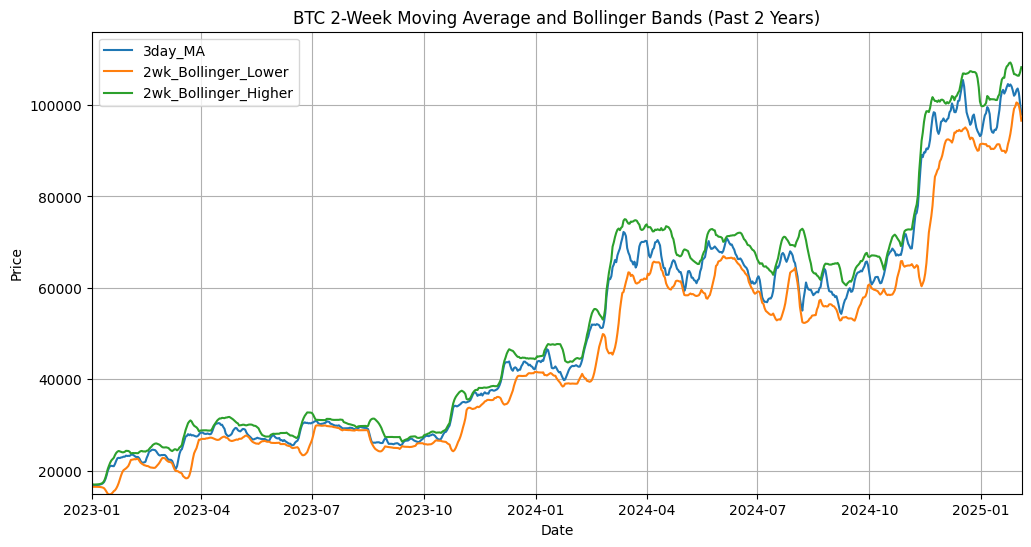

In [ ]:
#First take a look at BTC
plot_2_year(btc_df)

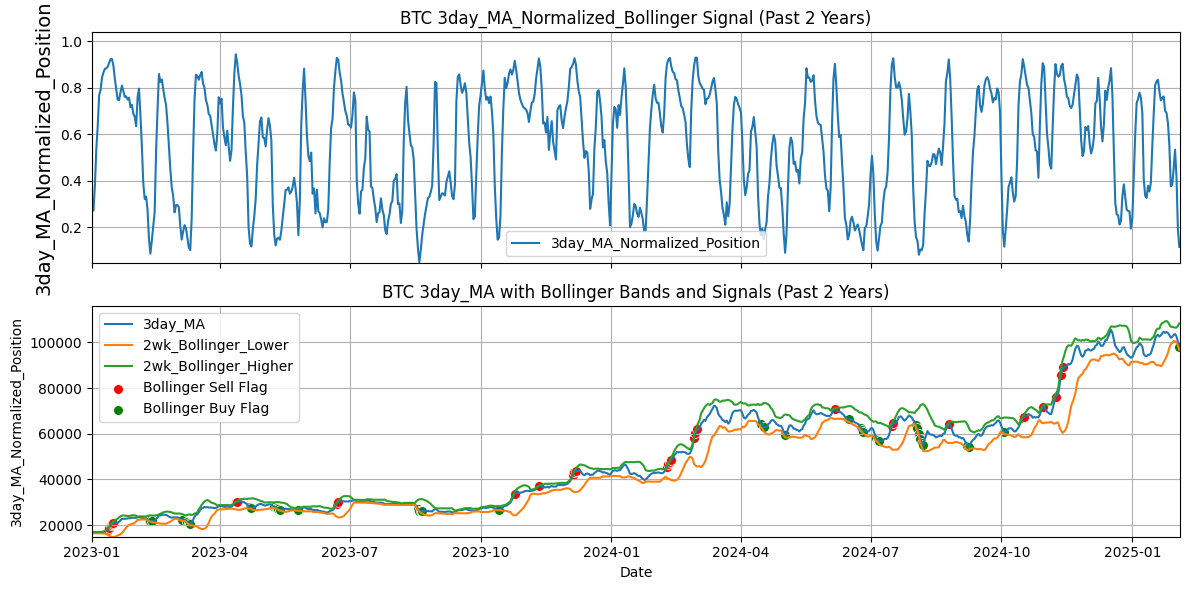

In [ ]:
plot_bollinger_signal_2_year(btc_df)

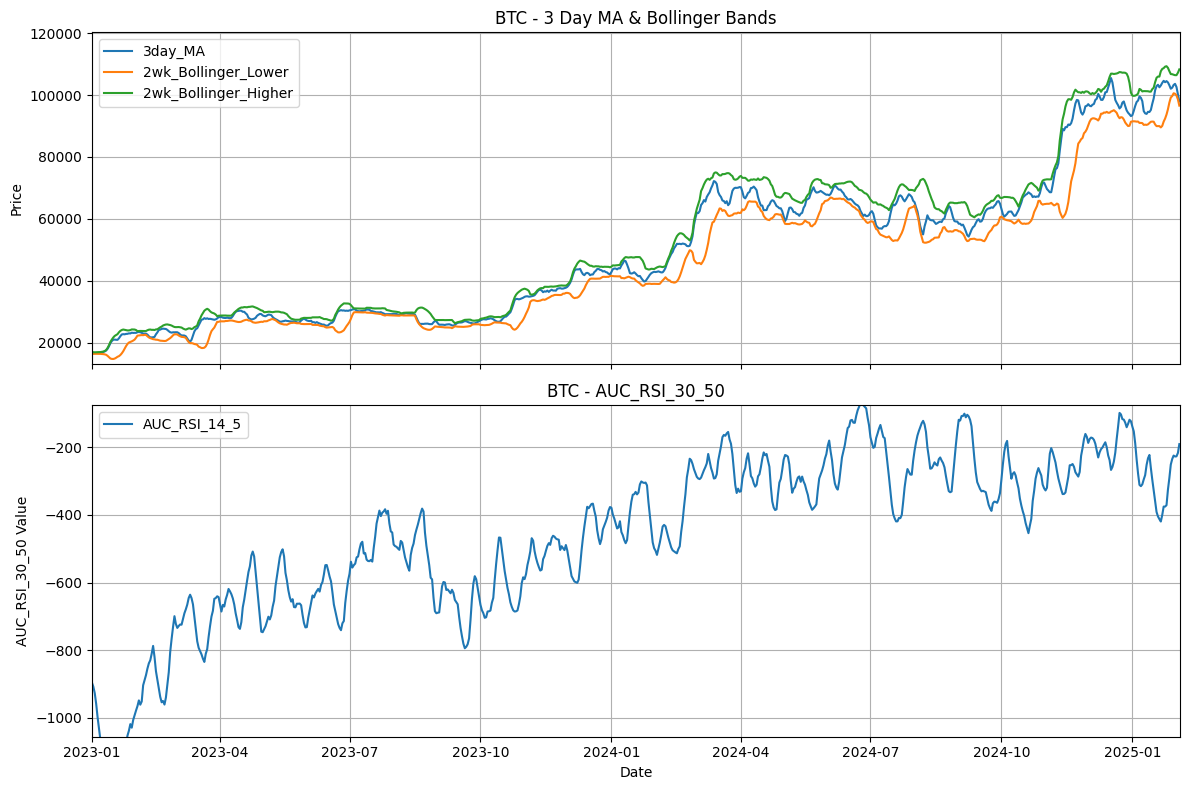

In [ ]:
#This is a Test indicator that I've been playing with

plot_AUC_RSI_30(btc_df)

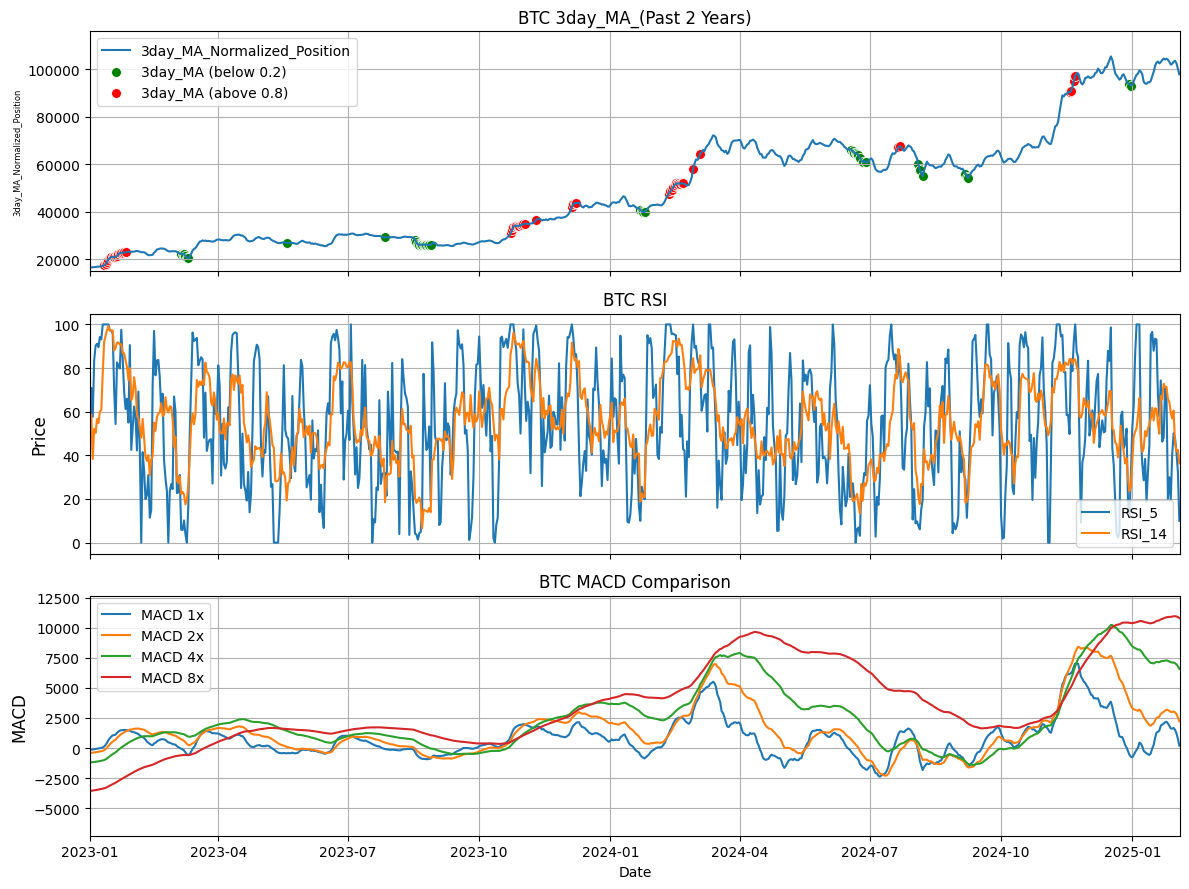

In [ ]:
plot_rsi_2_years(btc_df)

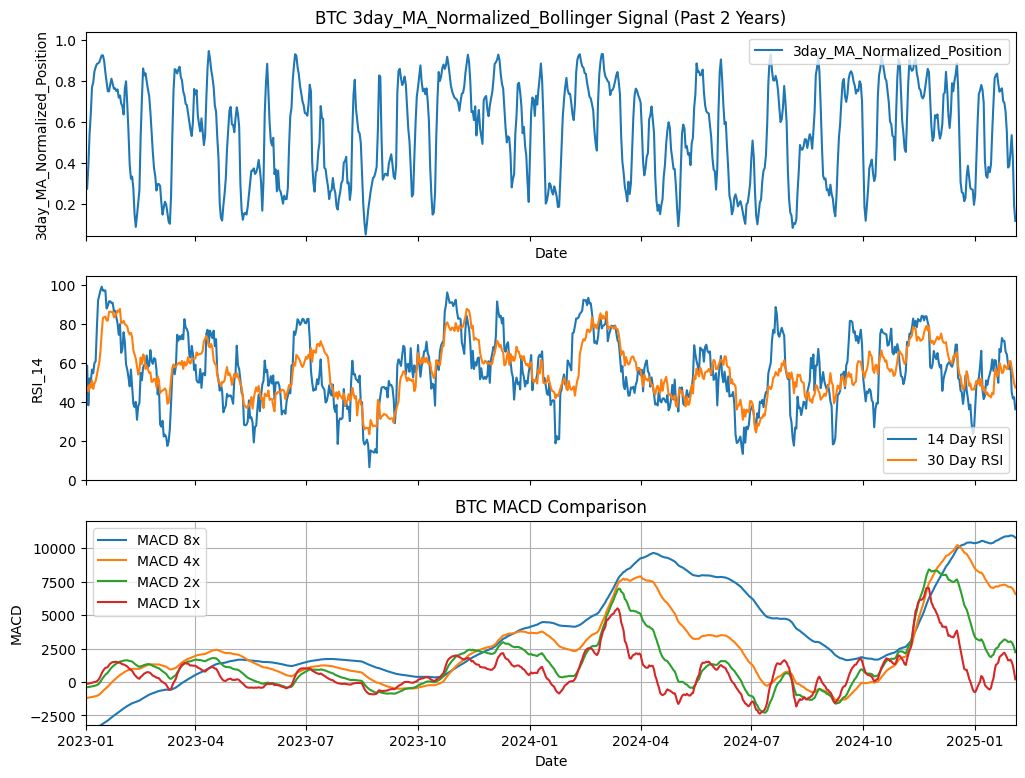

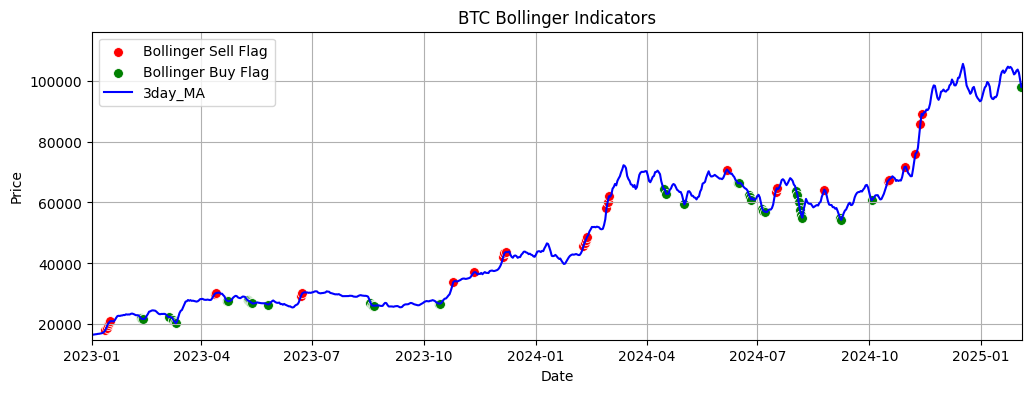

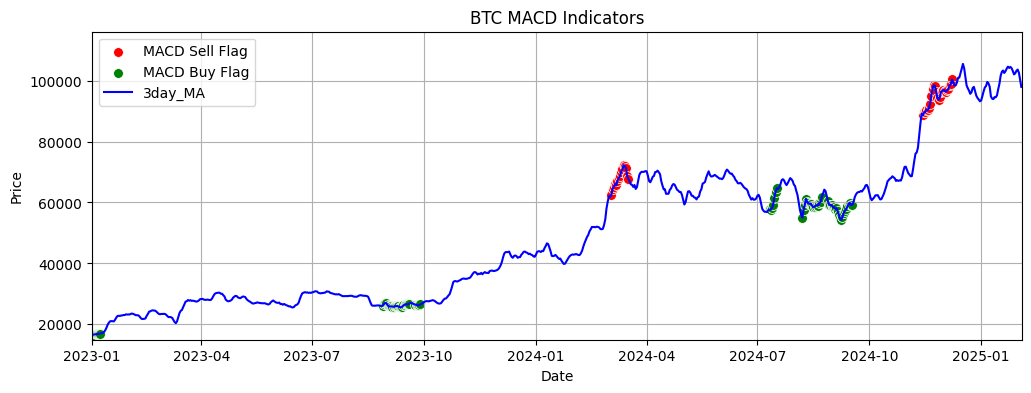

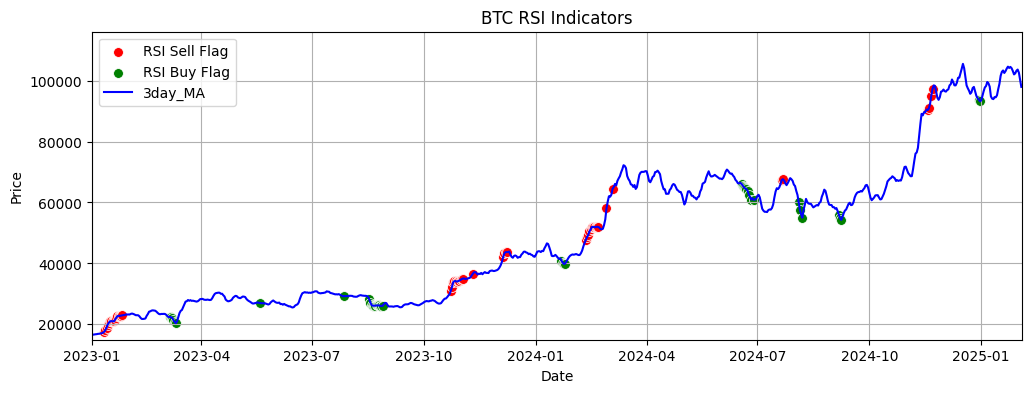

In [ ]:
plot_indicators(btc_df)
plot_flags(btc_df)

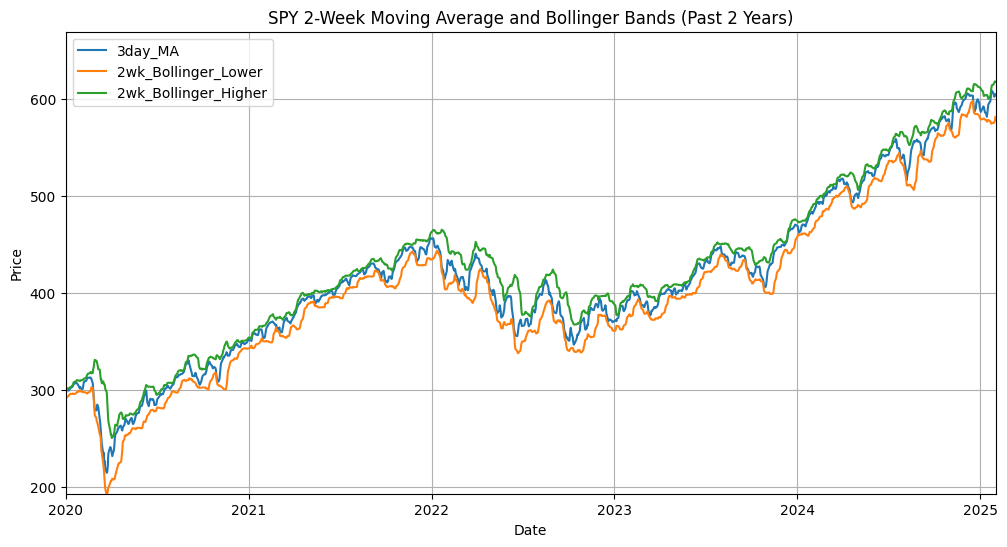

In [ ]:
# Now SPY
plot_2_year(spy_df)

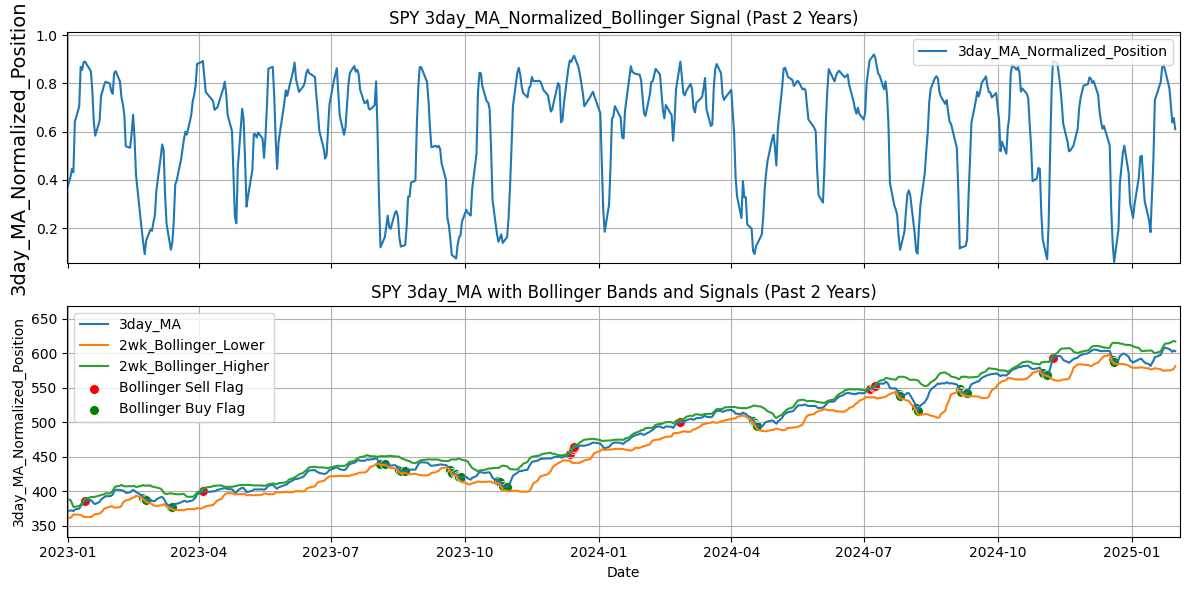

In [ ]:
plot_bollinger_signal_2_year(spy_df)

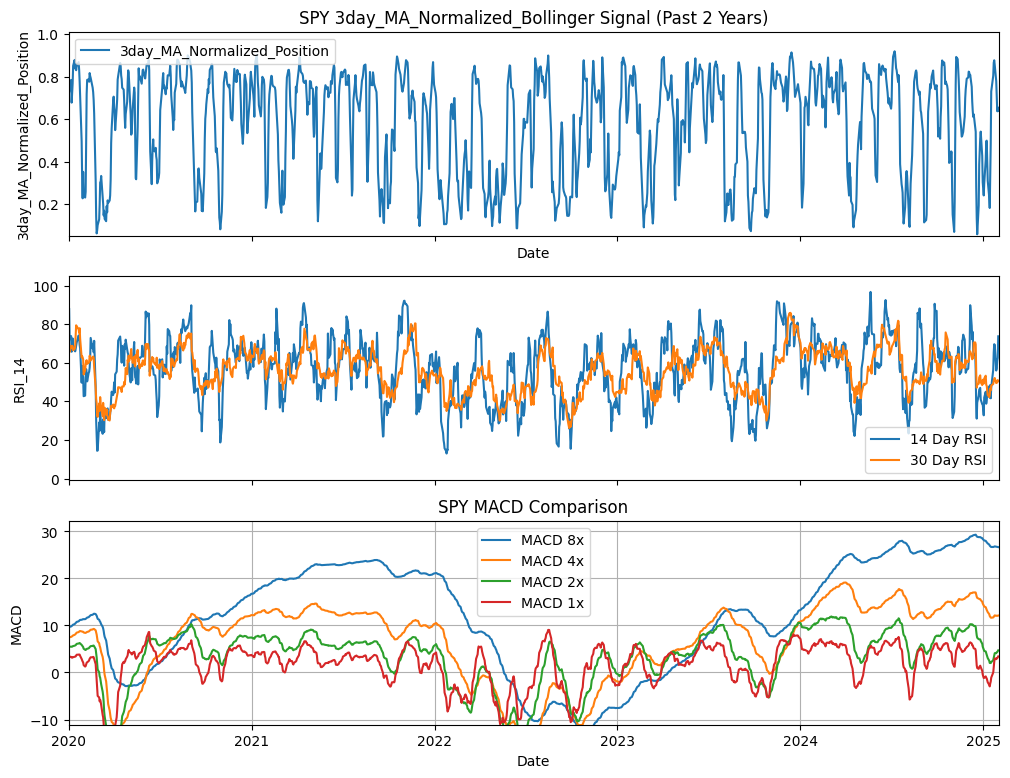

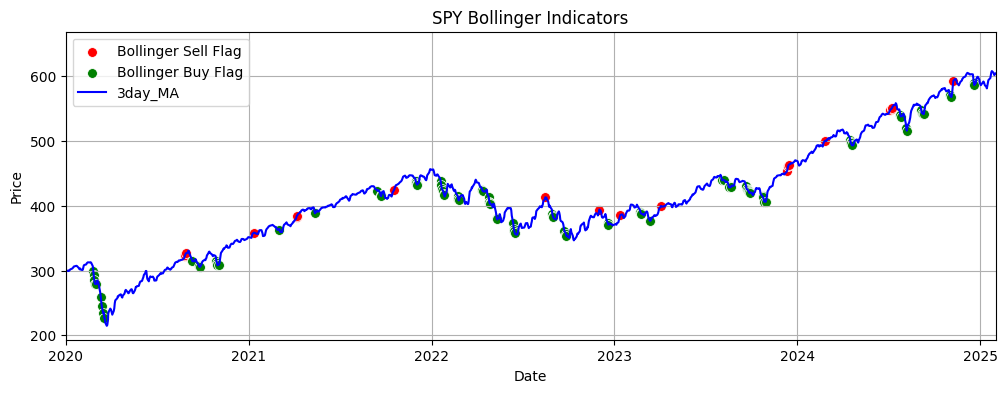

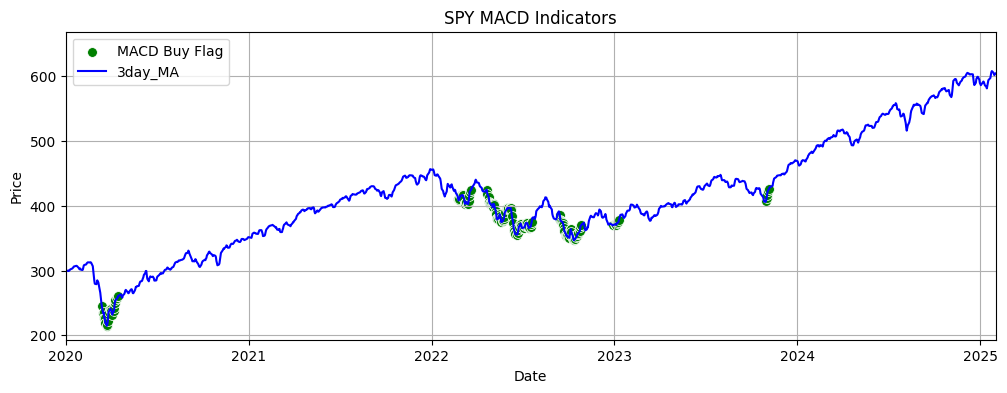

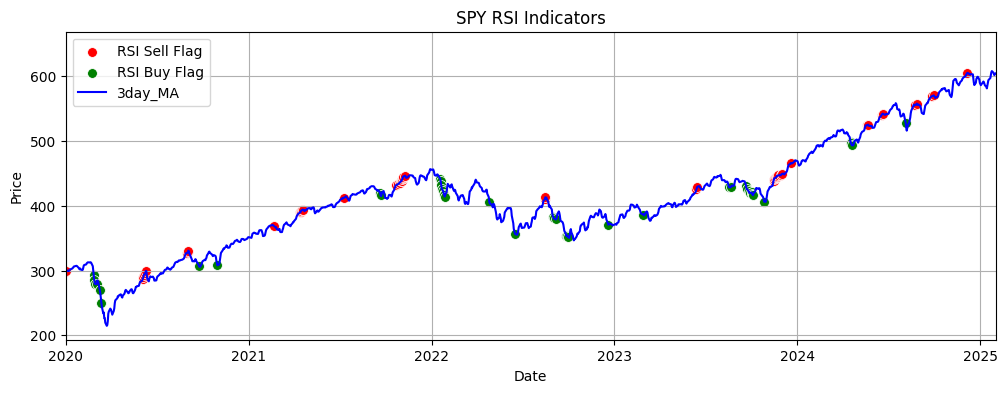

In [ ]:
plot_indicators(spy_df)
plot_flags(spy_df)

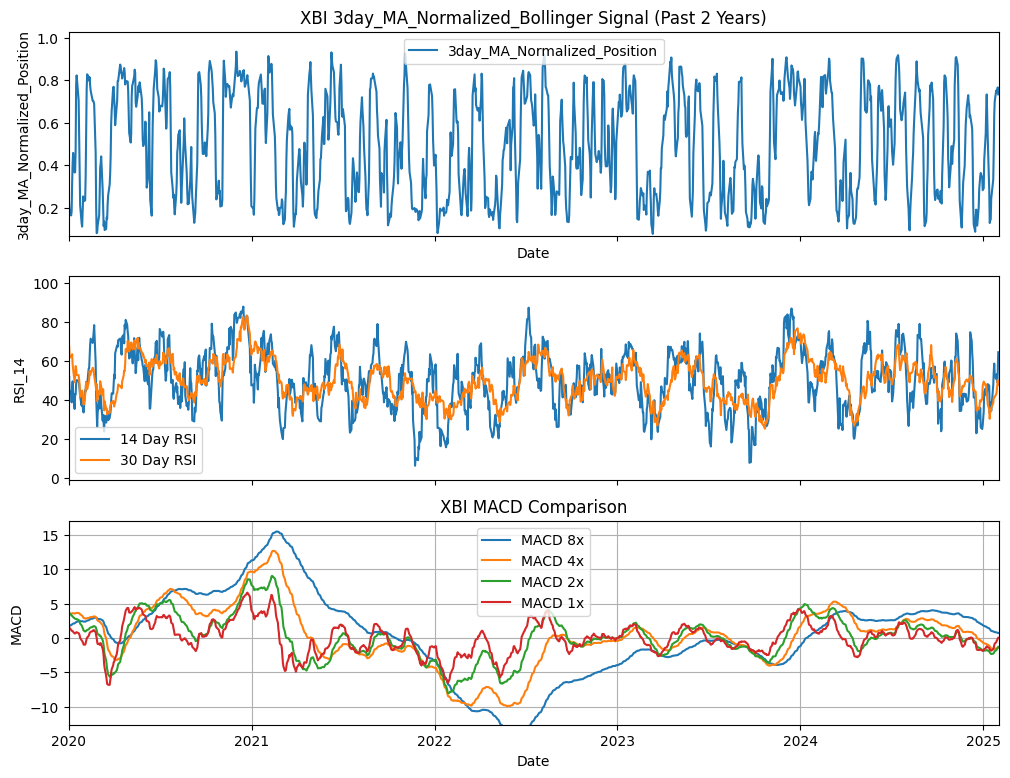

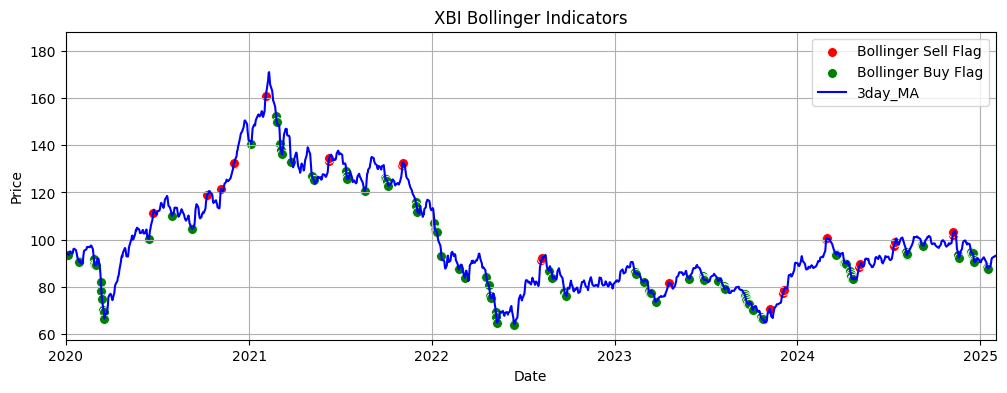

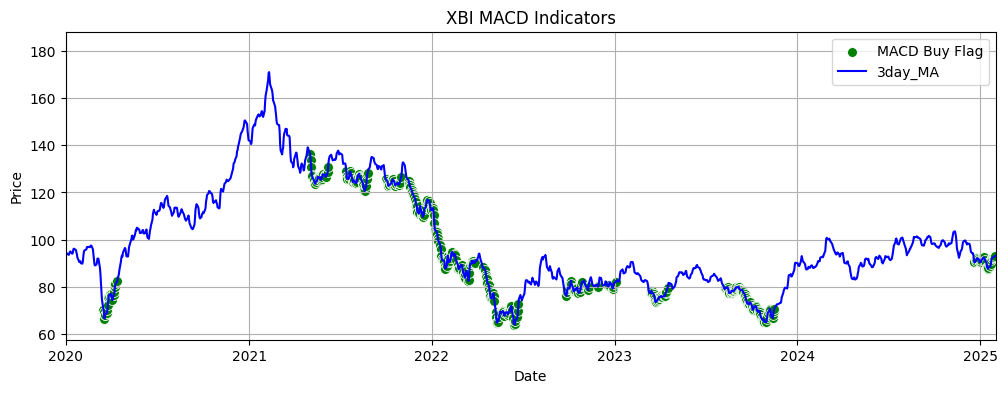

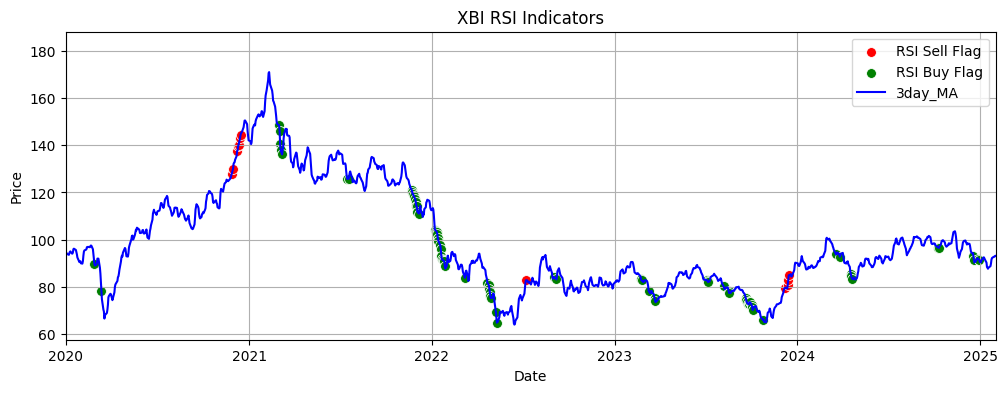

In [ ]:
#Now other randoms -- Note, these flags were designed around SPY and BTC, use at your own risk for other assets
plot_indicators(xbi_df)
plot_flags(xbi_df)

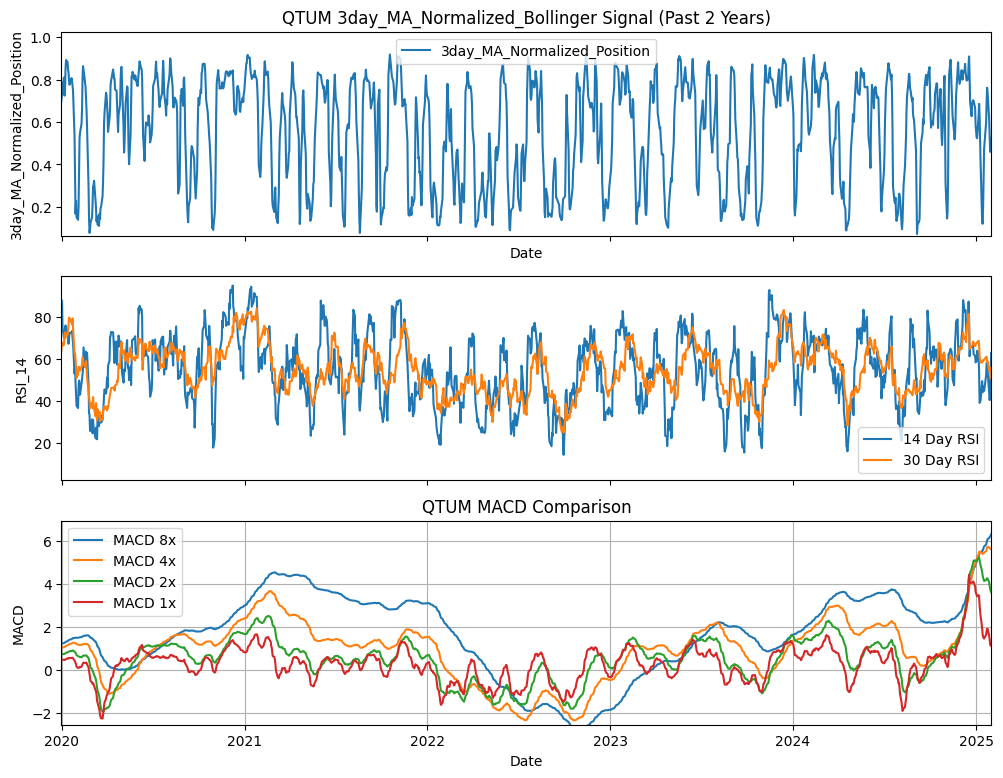

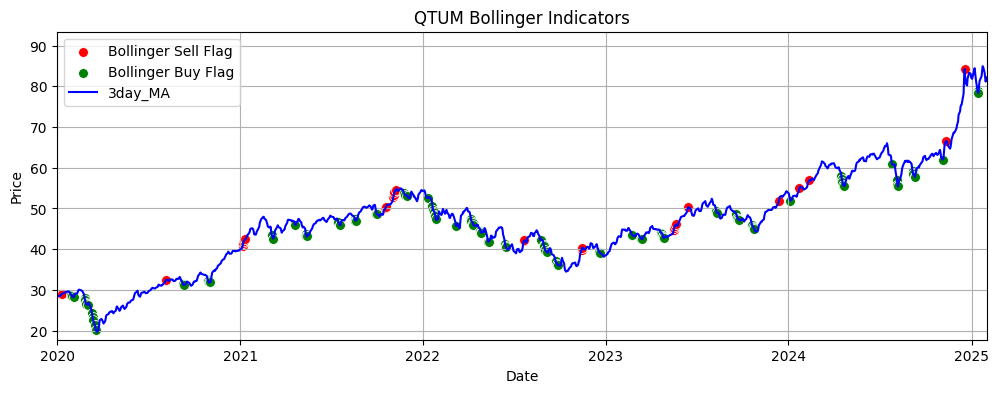

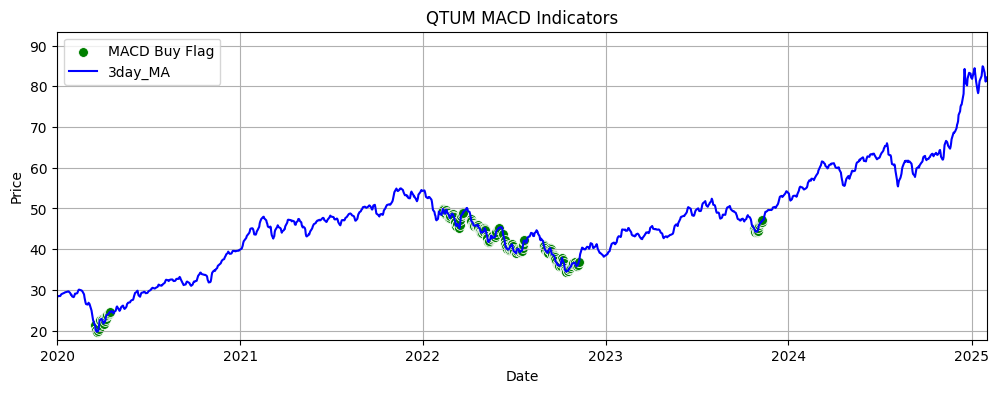

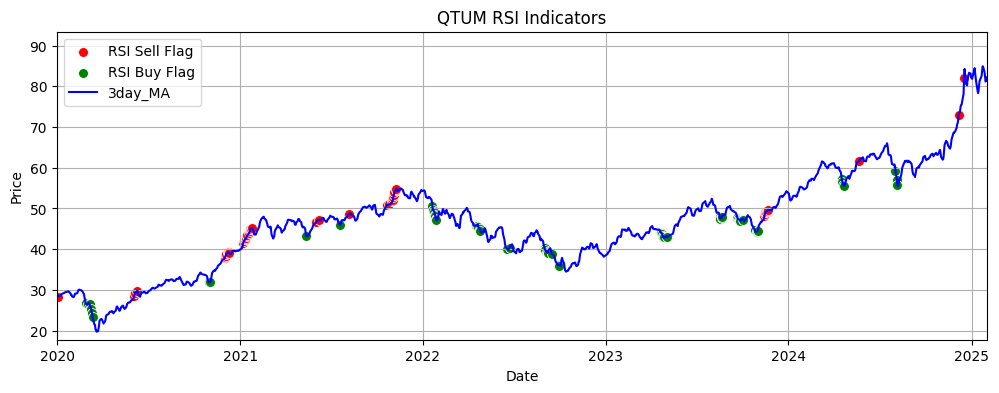

In [ ]:
plot_indicators(qtum_df)
plot_flags(qtum_df)

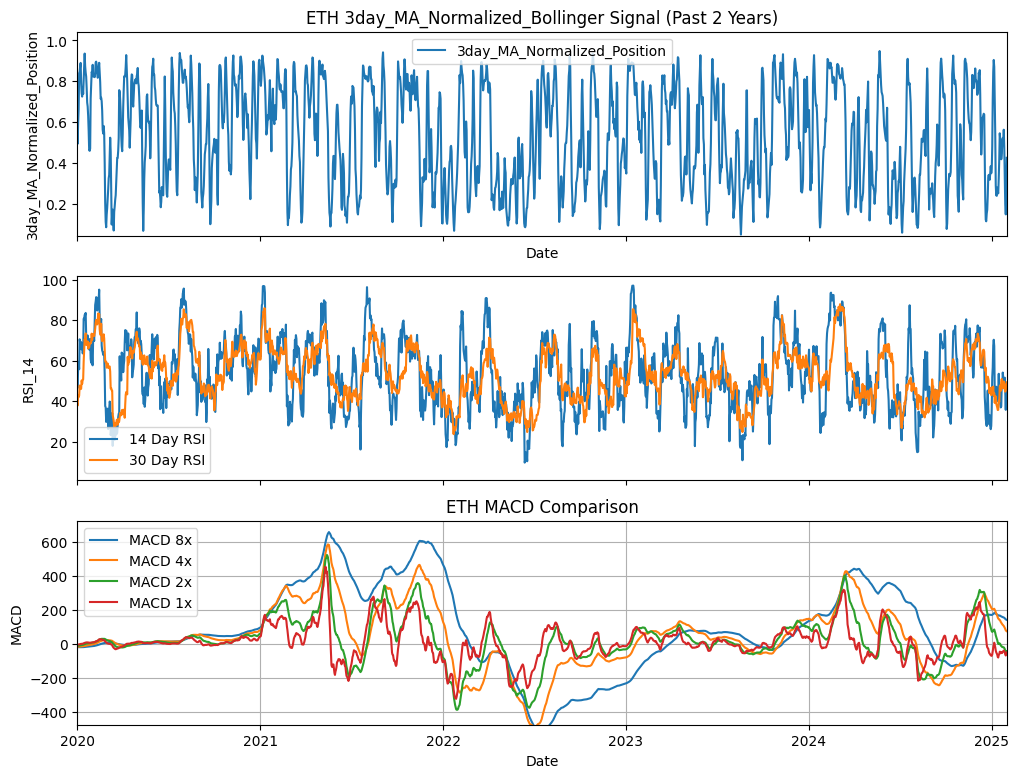

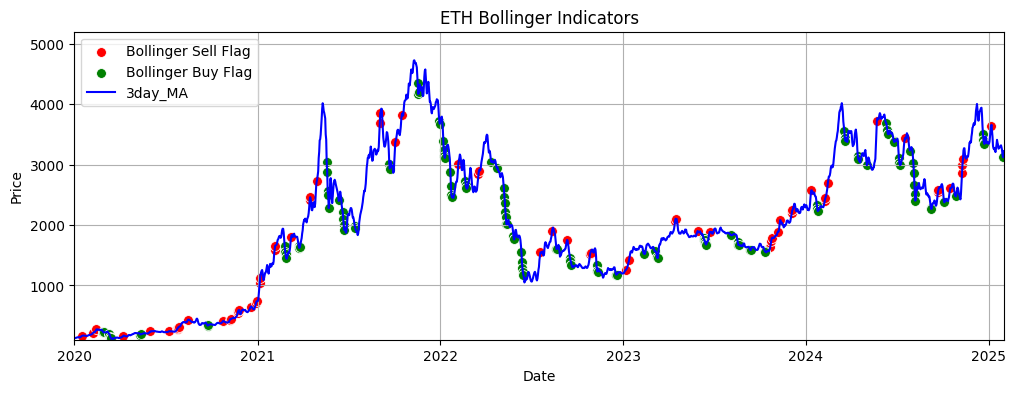

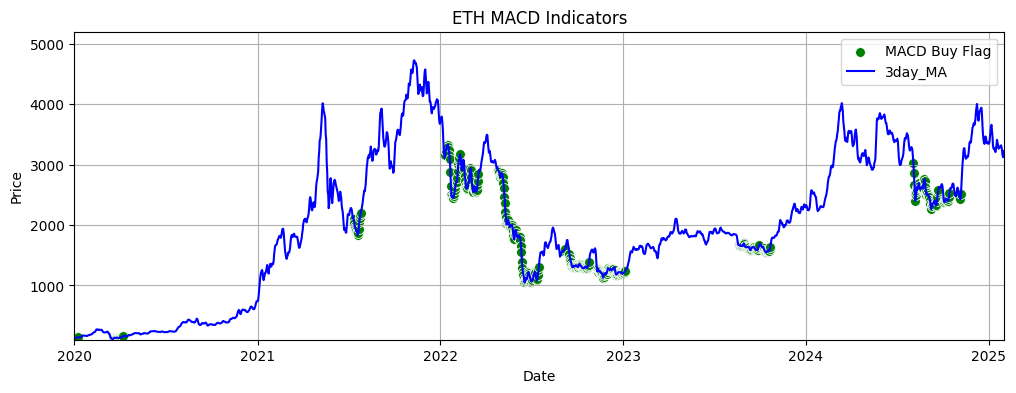

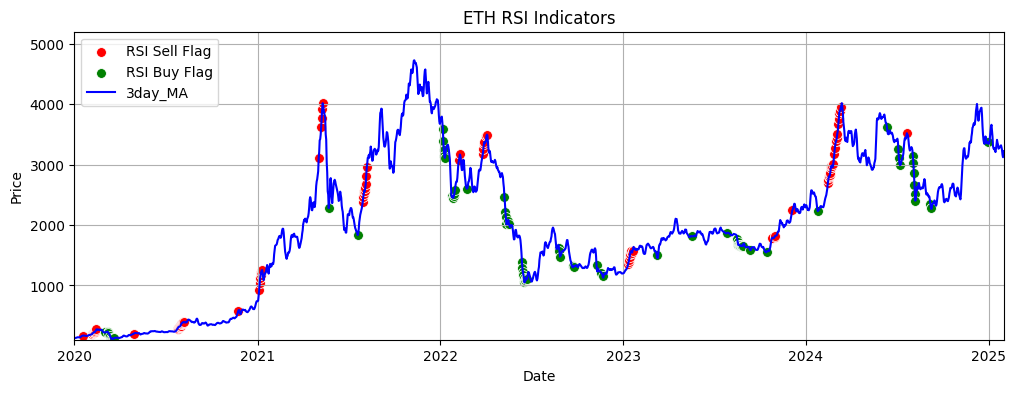

In [ ]:
plot_indicators(eth_df)
plot_flags(eth_df)

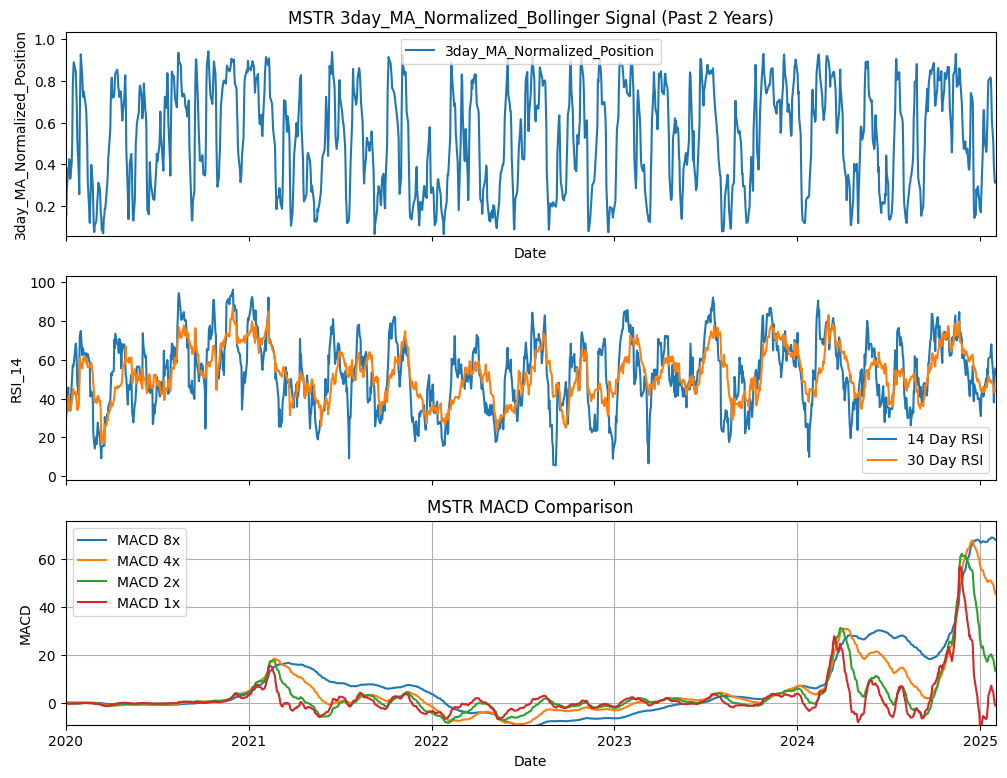

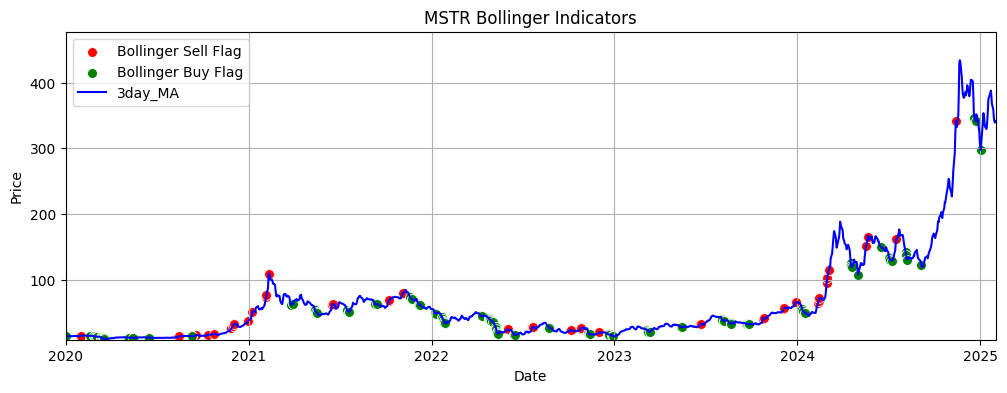

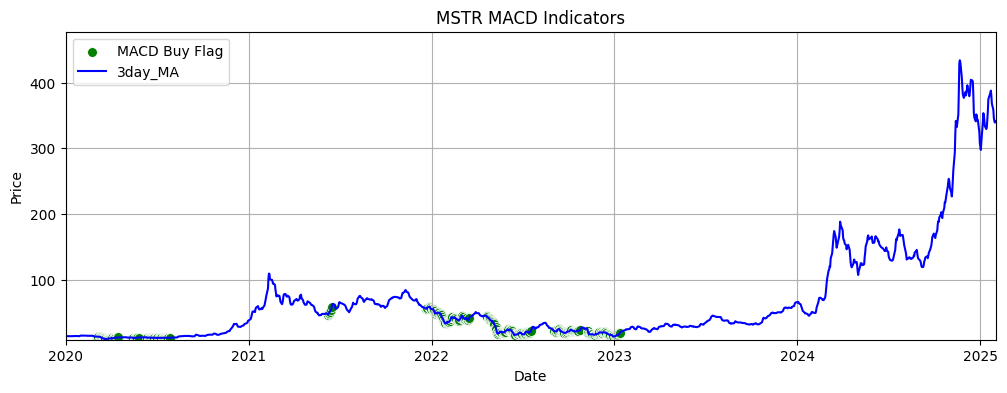

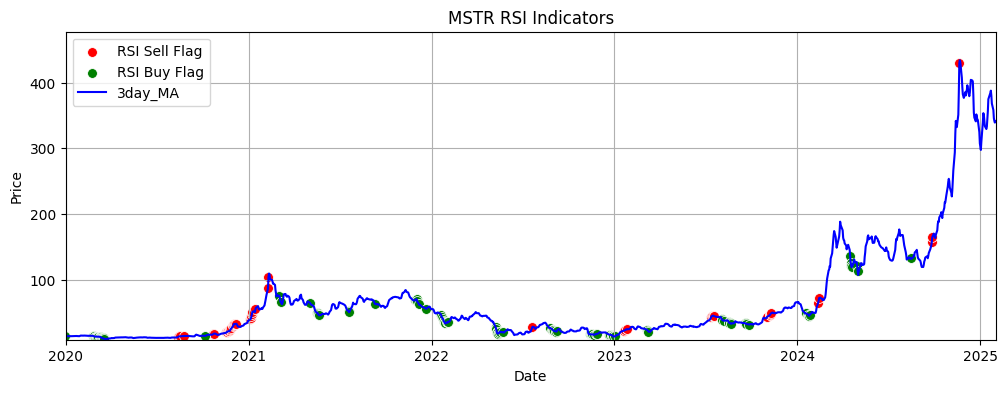

In [ ]:
plot_indicators(mstr_df)
plot_flags(mstr_df)

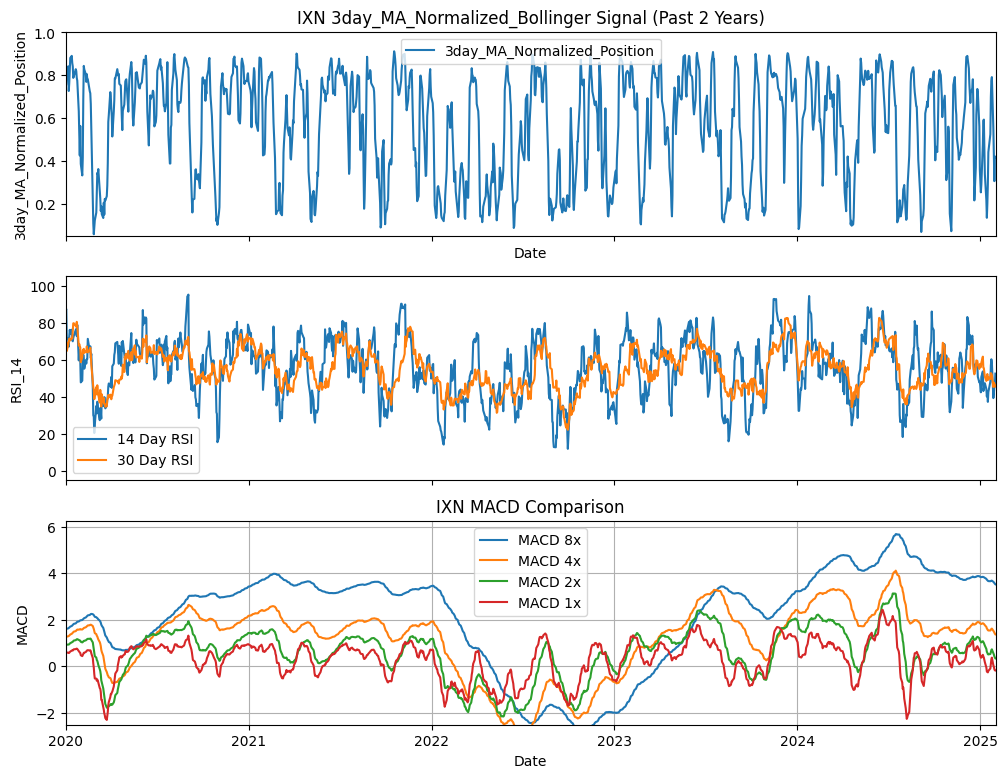

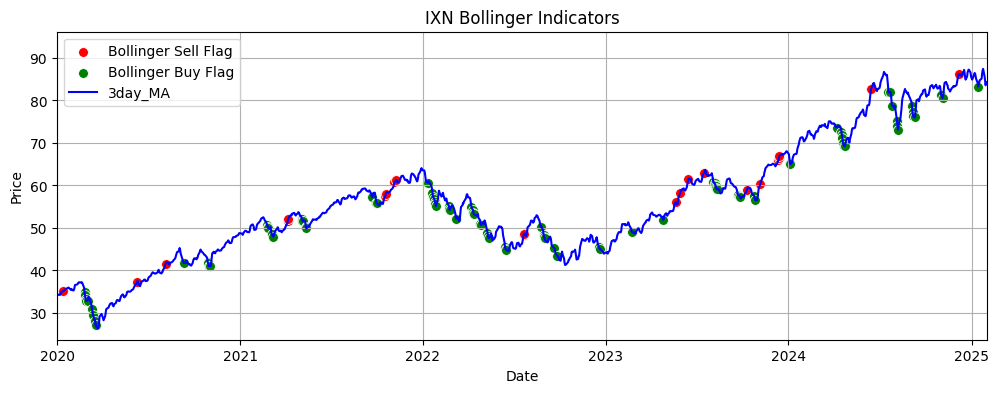

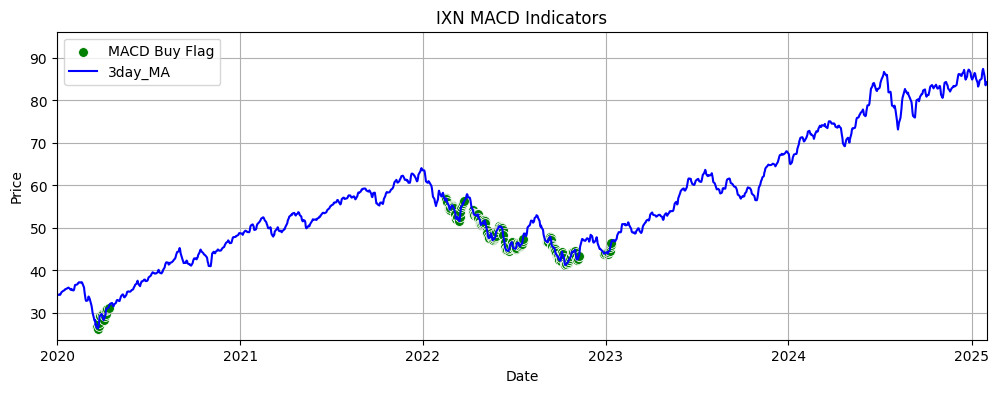

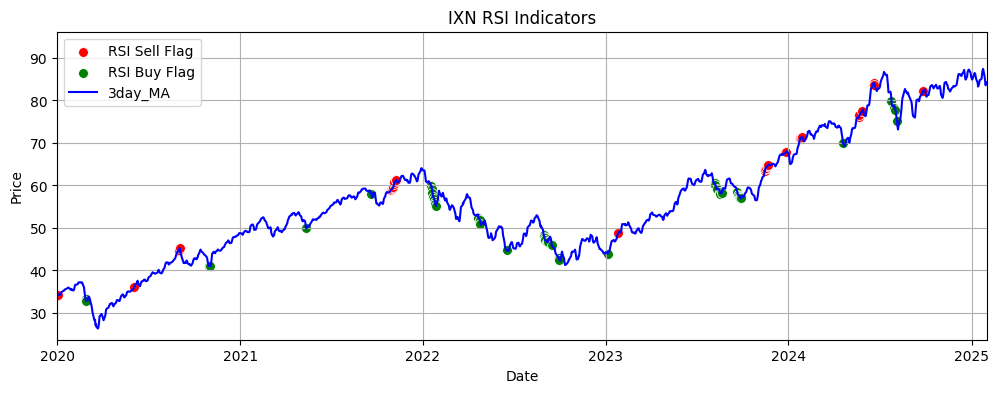

In [ ]:
plot_indicators(ixn_df)
plot_flags(ixn_df)

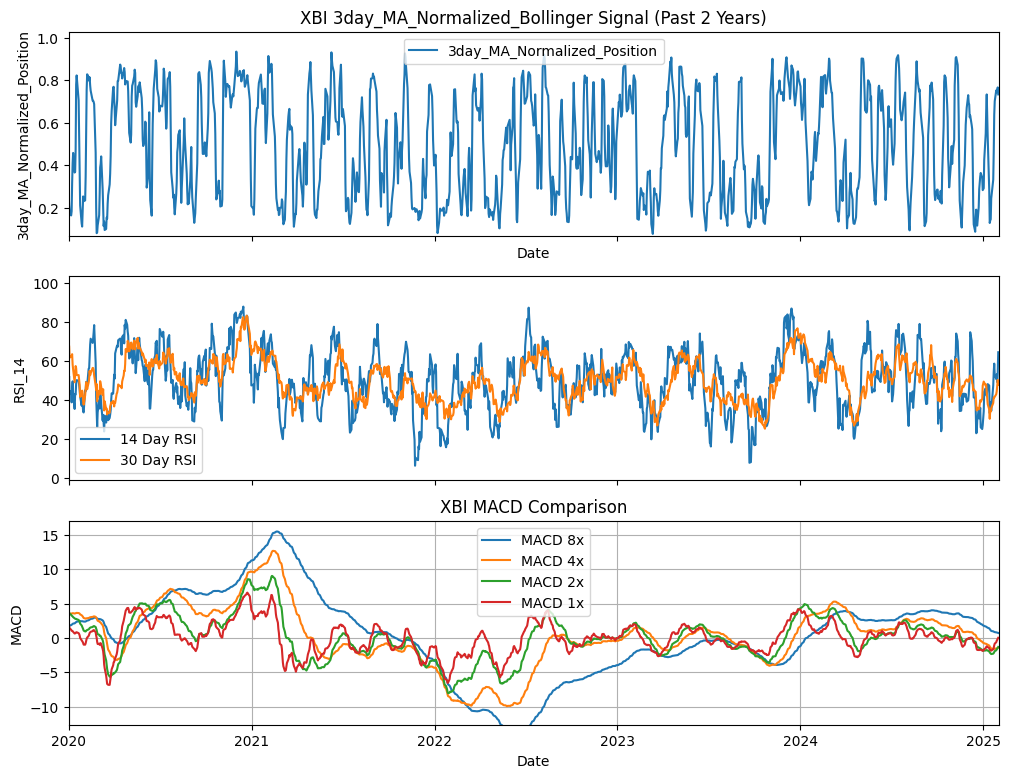

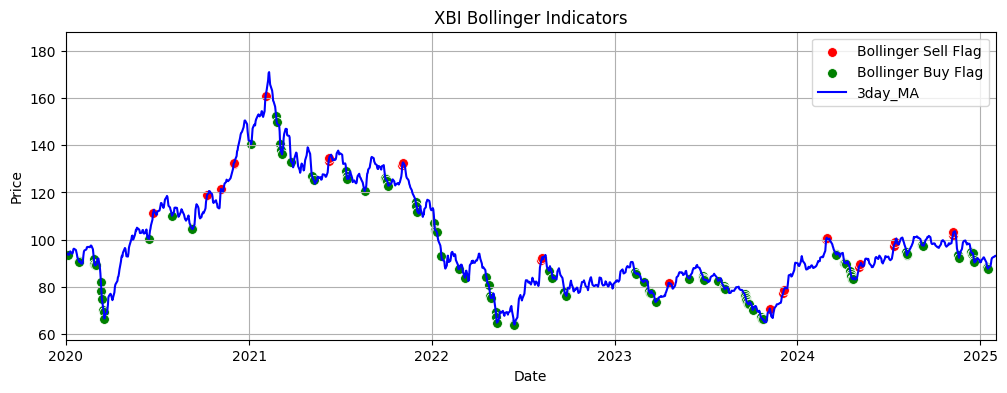

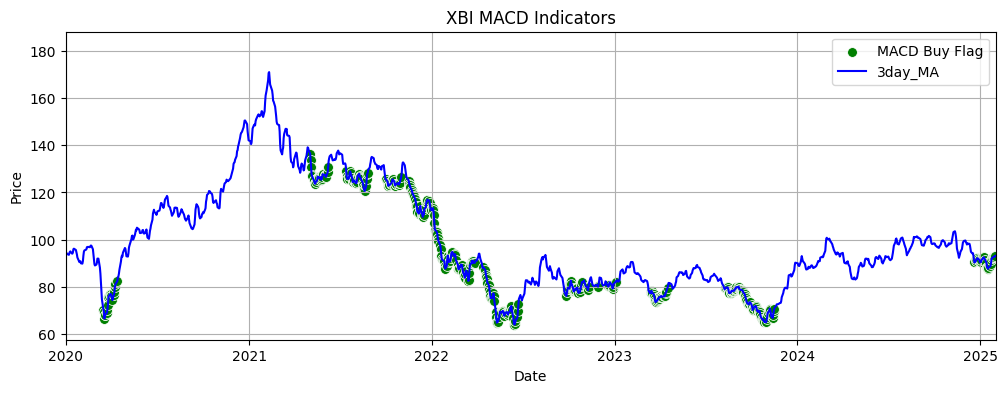

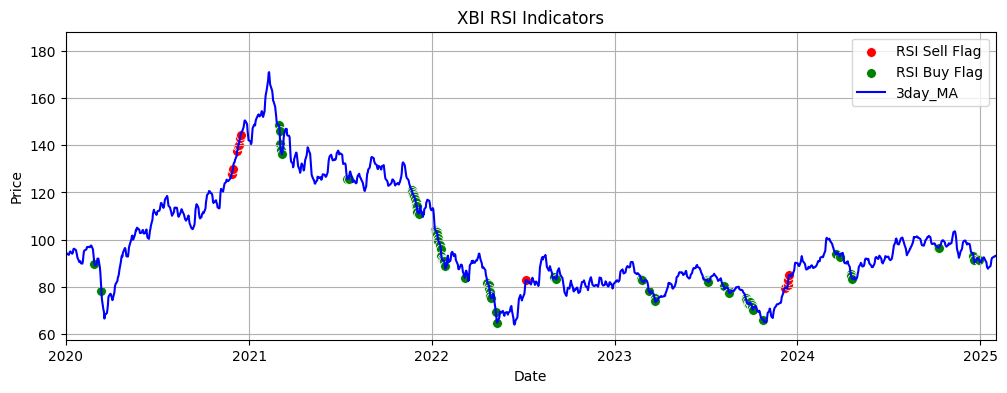

In [ ]:
plot_indicators(xbi_df)
plot_flags(xbi_df)

In [ ]:
# # Create the plot
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=btc_df, x=btc_df.index, y='Test Indicator #1A', label='Test Indicator #1A')
# sns.lineplot(data=btc_df, x=btc_df.index, y='Test Indicator #1B', label='Test Indicator #1B')
# plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp.today()) #Setting the x limit


# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.ylim(-10,10)
# plt.title("Bitcoin Test Indicator #1 (Past 1 Year)")
# plt.legend()
# plt.grid(True)
# plt.show()

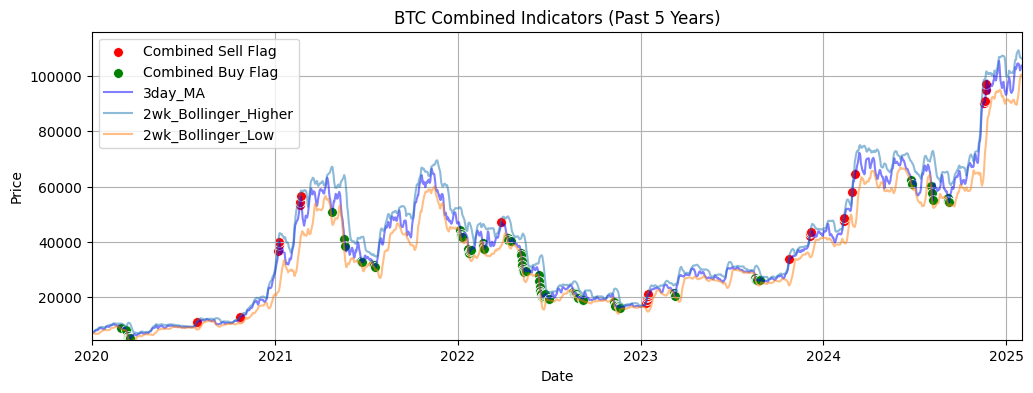

In [ ]:
plot_combined_indicators_2_years(btc_df)

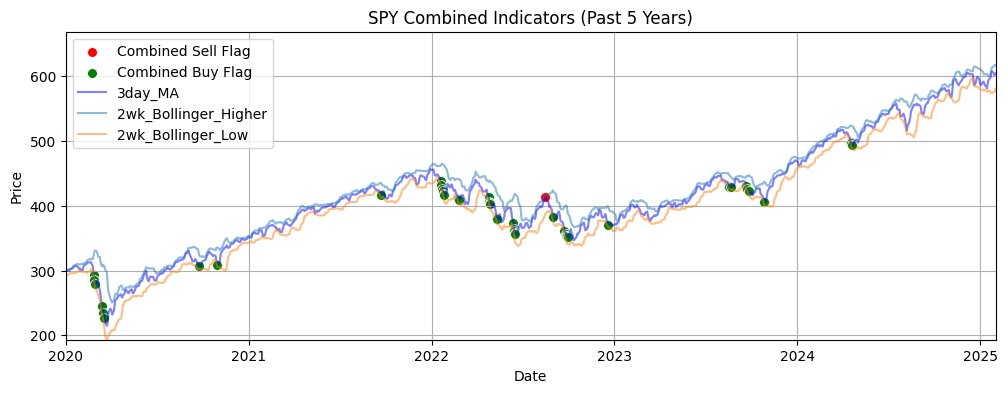

In [ ]:
plot_combined_indicators_2_years(spy_df)